In [84]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib

In [85]:
df = pd.read_csv('helpdesk.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      8115 non-null   datetime64[ns]
 1   priority        8115 non-null   object        
 2   experience_cat  8115 non-null   object        
 3   team_size       8115 non-null   int64         
 4   budget          8115 non-null   int64         
 5   type            8115 non-null   object        
 6   status          8115 non-null   object        
 7   end_date        6846 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 507.3+ KB


In [87]:
aantallen = df.groupby(['end_date']).size().reset_index(name='aantal')
aantallen[:20]

,end_date,aantal
0,2025-04-03,2
1,2025-04-04,2
2,2025-04-05,2
3,2025-04-06,2
4,2025-04-07,3
5,2025-04-08,7
6,2025-04-09,3
7,2025-04-10,1
8,2025-04-11,4
9,2025-04-12,4


In [88]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used",],)
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",
    nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# voer ADF-test uit
adf_test(aantallen['aantal'])
kpss_test(aantallen['aantal'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.542557
p-value                          0.105460
#Lags Used                       6.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64
Results of KPSS Test:
Test Statistic           1.856092
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3800699/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


> Hij is nog niet stationair, dit gaan we hem maken


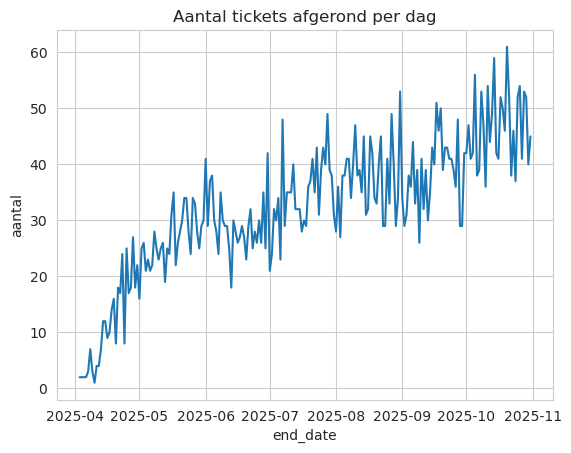

In [89]:
sns.lineplot(aantallen, x='end_date', y='aantal')
plt.title("Aantal tickets afgerond per dag")
plt.show()

In [90]:
aantallen['aantal_boxcox'], fitted_lambda = scipy.stats.boxcox(aantallen['aantal'])
fitted_lambda

1.1958940463542014

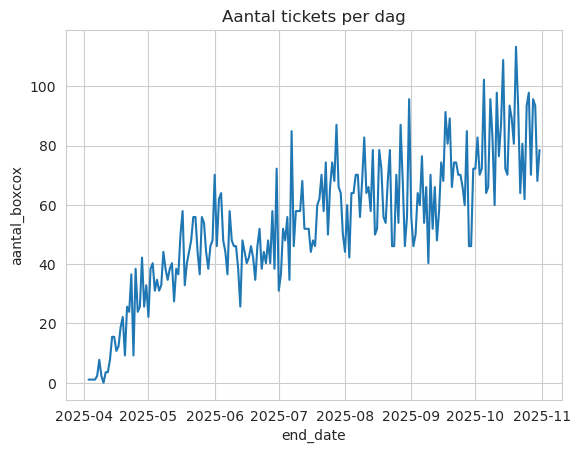

In [91]:
sns.lineplot(aantallen, x='end_date', y='aantal_boxcox')
plt.title("Aantal tickets per dag")
plt.show()

In [92]:
adf_test(aantallen['aantal_boxcox'])
kpss_test(aantallen['aantal_boxcox'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.214416
p-value                          0.201055
#Lags Used                       5.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Results of KPSS Test:
Test Statistic           1.903719
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_3800699/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


In [93]:
aantallen['aantal_boxcox_detrend'] = aantallen['aantal_boxcox'] - \
                                                     aantallen['aantal_boxcox'].shift(1)

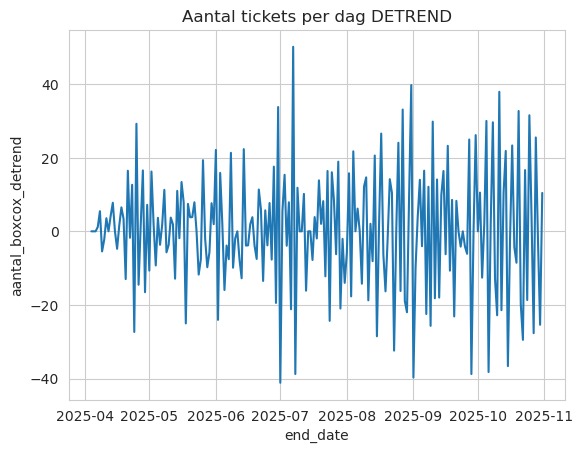

In [94]:
sns.lineplot(aantallen, x='end_date', y='aantal_boxcox_detrend')
plt.title("Aantal tickets per dag DETREND")
plt.show()

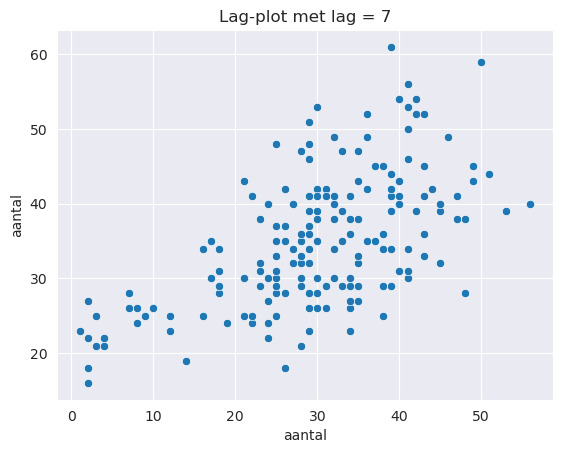

In [95]:
sns.set_style('darkgrid')
sns.scatterplot(aantallen,
x = aantallen.shift(25)['aantal'],
y = aantallen['aantal'])
plt.title("Lag-plot met lag = 7")
plt.ticklabel_format(axis='both', style='plain')
plt.show()
                          


In [96]:
# functie voor plotten van time series
def plot_series(df, series_name, lags=40, diff=0, seasonal_diff=0, seasonal_period=12):
    """
    Plot a time series alongside its ACF and PACF with Bartlett bounds.
    Includes options for regular and seasonal differencing.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing multiple time series as columns.
    series_name : str
        Column name of the series to plot.
    lags : int
        Number of lags for ACF/PACF.
    diff : int, default=0
        Number of regular differences to apply.
    seasonal_diff : int, default=0
        Number of seasonal differences to apply.
    seasonal_period : int, default=12
        Seasonal period (e.g., 12 for monthly data with yearly seasonality).
    """
    series = df[series_name]

    # Apply differencing
    for _ in range(diff):
        series = series.diff()
    for _ in range(seasonal_diff):
        series = series.diff(seasonal_period)
    series = series.dropna()
    
    print(adf_test(series))
    print(kpss_test(series))

    # Compute ACF/PACF (drop lag 0)
    acf_vals = acf(series, nlags=lags, fft=False)[1:]
    pacf_vals = pacf(series, nlags=lags, method="ywm")[1:]
    lags_range = np.arange(1, len(acf_vals)+1)

    # Bartlett bounds
    n = len(series)
    conf = 1.96 / np.sqrt(n)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Time series
    axes[0].plot(series.index, series.values, color="steelblue")
    axes[0].set_title(f"Series: {series_name} (diff={diff}, seas_diff={seasonal_diff})")

    # ACF
    axes[1].stem(lags_range, acf_vals, basefmt=" ")
    axes[1].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[1].axhline(0, color="black", linewidth=0.8)
    axes[1].set_title("ACF-plot")

    # PACF
    axes[2].stem(lags_range, pacf_vals, basefmt=" ")
    axes[2].hlines([conf, -conf], xmin=0, xmax=lags, colors="red", linestyles="dashed")
    axes[2].axhline(0, color="black", linewidth=0.8)
    axes[2].set_title("PACF-plot")

    plt.tight_layout()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.542557
p-value                          0.105460
#Lags Used                       6.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64
None
Results of KPSS Test:
Test Statistic           1.856092
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/tmp/ipykernel_3800699/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


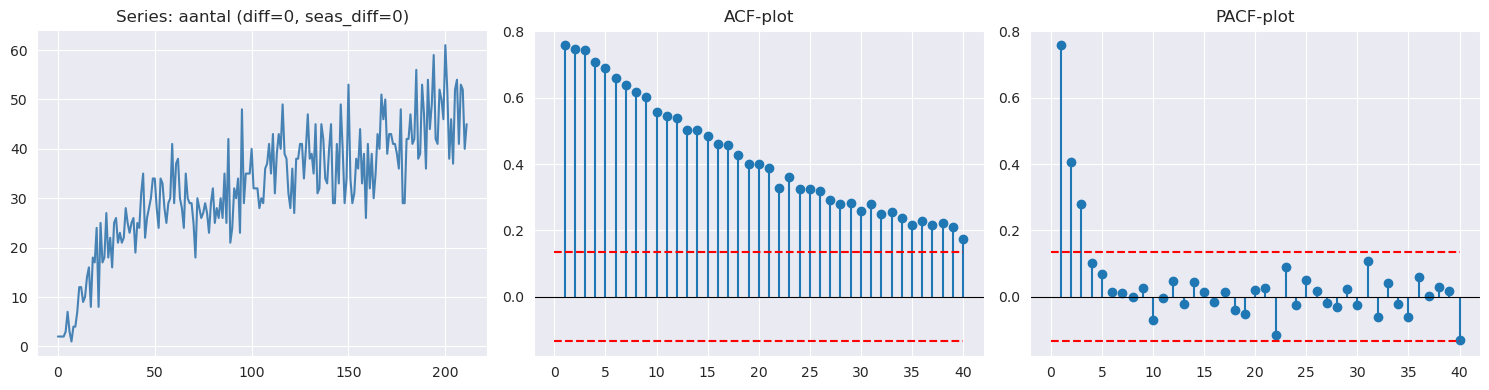

In [97]:
plot_series(aantallen, 'aantal', lags=40)

Results of Dickey-Fuller Test:
Test Statistic                -9.103845e+00
p-value                        3.546090e-15
#Lags Used                     5.000000e+00
Number of Observations Used    2.050000e+02
Critical Value (1%)           -3.462658e+00
Critical Value (5%)           -2.875744e+00
Critical Value (10%)          -2.574341e+00
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.178608
p-value                   0.100000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


/tmp/ipykernel_3800699/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


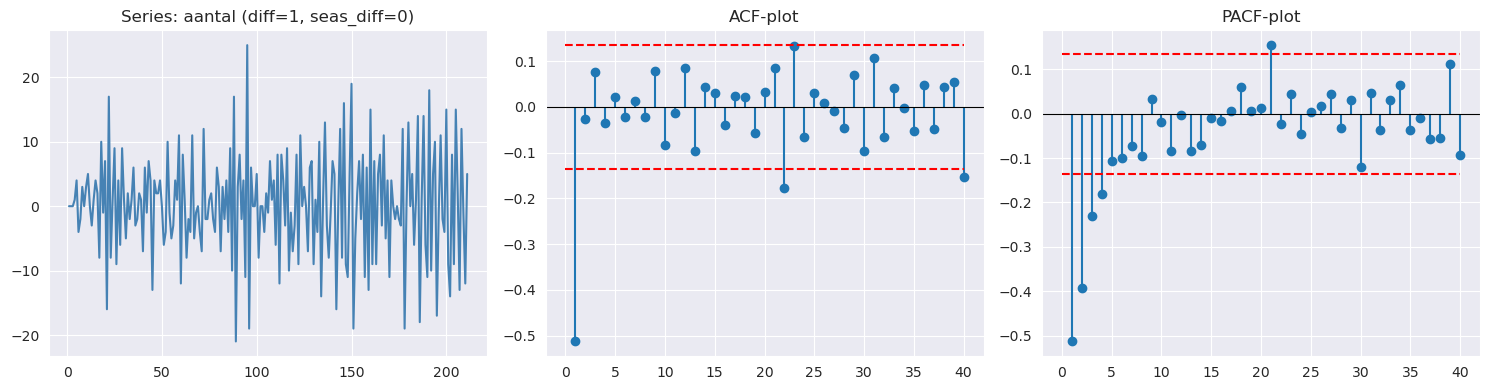

In [98]:
plot_series(aantallen, 'aantal', lags=40, diff=1)

seasonality in ACF gevonden, door de tellen naar elk hoogste punt, er zit telkens 14 dagen? tussen, dus voor sarima is m = 14.

Hij is ook minder toenemend met seasonal differencing 1 dan zonder, dus hij is nu ook meer stationair.

in ACF oscillerende dempend, P = 1
in de pacf ziet yaika dempend oscillerend, dus Q=1

onze seasonal differencing was D=1

p = 1
q = 1
d= 0


In [112]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 aantal   No. Observations:                  212
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -680.419
Date:                Wed, 21 Jan 2026   AIC                           1370.838
Time:                        12:13:37   BIC                           1387.597
Sample:                             0   HQIC                          1377.613
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1681      0.143     -1.174      0.240      -0.449       0.113
ar.L2         -0.1072      0.122     -0.880      0.379      -0.346       0.132
ar.L3          0.0131      0.116      0.113      0.910      -0.214       0.240
ma.L1         -0.7000      0.133     -5.246      0.000      -0.961      -0.438
sigma2        36.8453      3.773      9.766      0.000      29.451      44.240
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.70   Prob(JB):                         0.71
Heteroskedasticity (H):               2.28   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

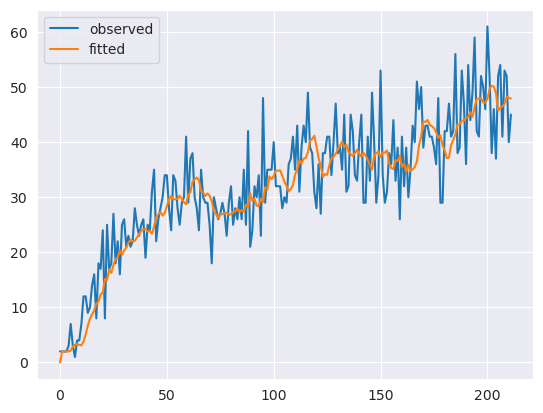

In [116]:
model = ARIMA(aantallen["aantal"], order=(3,1,1))
fitted = model.fit()

y = aantallen["aantal"]
fv = fitted.fittedvalues

y_aligned, fv_aligned = y.align(fv, join="inner")

plt.plot(y_aligned.index, y_aligned, label="observed")
plt.plot(fv_aligned.index, fv_aligned, label="fitted")
plt.legend()
plt.show()


In [117]:
forecast_res = fitted.get_forecast(steps=30)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

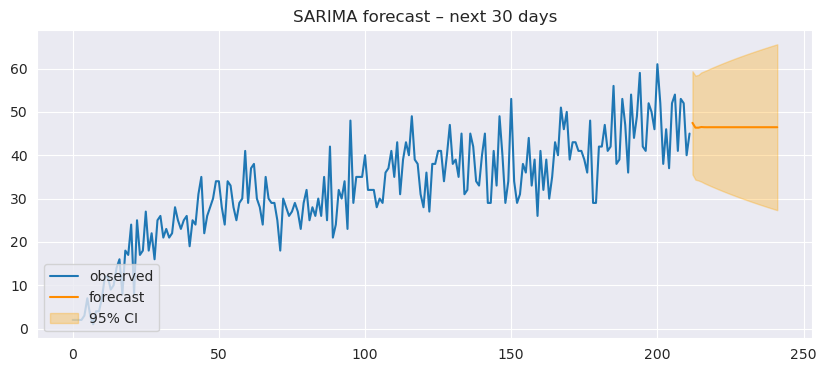

In [118]:
plt.figure(figsize=(10,4))

plt.plot(y.index, y, label="observed")
plt.plot(forecast_mean.index, forecast_mean, label="forecast", color="darkorange")

plt.fill_between(    forecast_ci.index,    forecast_ci.iloc[:, 0],    forecast_ci.iloc[:, 1],color="orange",    alpha=0.3,    label="95% CI")

plt.legend(loc='lower left')
plt.title("SARIMA forecast – next 30 days")
plt.show()


In [119]:
sum(forecast_mean)

1394.8048548293189

In [103]:
forecast_mean

212    47.477441
213    46.367802
214    46.354071
215    46.507763
216    46.468886
217    46.458762
218    46.466643
219    46.465895
220    46.465043
221    46.465370
222    46.465396
223    46.465346
224    46.465356
225    46.465360
226    46.465357
227    46.465357
228    46.465358
229    46.465358
230    46.465358
231    46.465358
232    46.465358
233    46.465358
234    46.465358
235    46.465358
236    46.465358
237    46.465358
238    46.465358
239    46.465358
240    46.465358
241    46.465358
Name: predicted_mean, dtype: float64

VRAAG A IS BEANTWOORD!!!

In [46]:
series = (df.groupby('end_date')
            .size()
            .asfreq('D', fill_value=0)
            .rename('aantal'))
y = np.log1p(series)


In [54]:
from pmdarima import auto_arima

model = auto_arima(
    y,                      # of series als je geen log gebruikt
    start_p=3,
    start_q=1,
    max_p=5,
    max_q=3,
    start_P=0,
    start_Q=0,
    max_P=2,
    max_Q=2,
    d=1,
    D=1,
    seasonal=False,
    m=7,
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True
)


/home/s24144738/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-19.287, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.334, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6.925, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21.907, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.799, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20.803, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-21.078, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-29.521, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-26.920, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-24.123, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-21.624, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20.113, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-25.069, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-30.996, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-18.434, 

In [56]:
aantallen['aantal_boxcox'], fitted_lambda = scipy.stats.boxcox(aantallen['aantal'])
fitted_lambda

0.24609811707668786

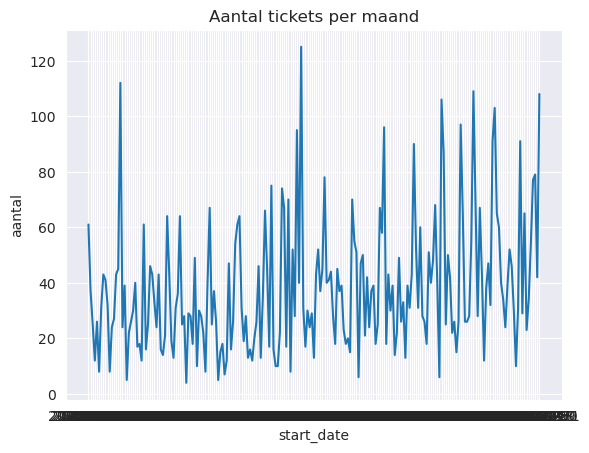

In [83]:
sns.lineplot(data=aantallen, x='start_date', y='aantal')
plt.title("Aantal tickets per maand")
plt.show()

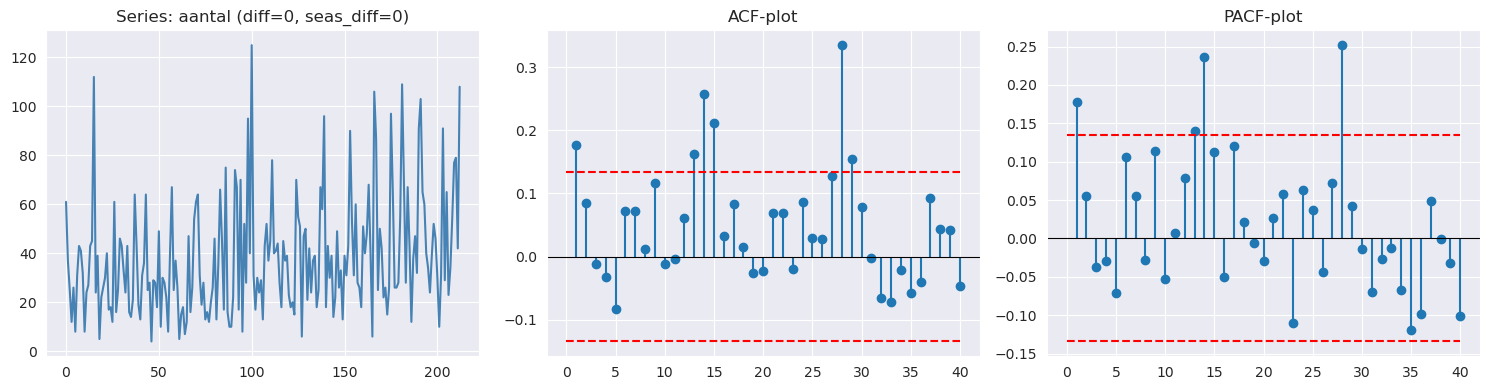

In [82]:
plot_series(aantallen, 'aantal', diff=0)

In [71]:
aantallen['aantal_boxcox_detrend'] = aantallen['aantal_boxcox'] - \
                                                     aantallen['aantal_boxcox'].shift(2)

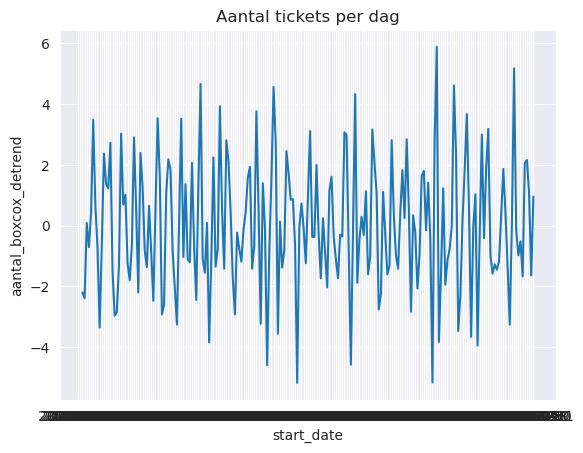

In [72]:
sns.lineplot(data=aantallen, x='start_date', y='aantal_boxcox_detrend')
plt.title("Aantal tickets per dag")
plt.show()

In [73]:
adf_test(aantallen['aantal_boxcox_detrend'].dropna())
kpss_test(aantallen['aantal_boxcox_detrend'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.425543e+00
p-value                        6.563614e-11
#Lags Used                     1.500000e+01
Number of Observations Used    1.950000e+02
Critical Value (1%)           -3.464337e+00
Critical Value (5%)           -2.876479e+00
Critical Value (10%)          -2.574733e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.210045
p-value                   0.100000
Lags Used                47.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_3004756/3735277516.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",


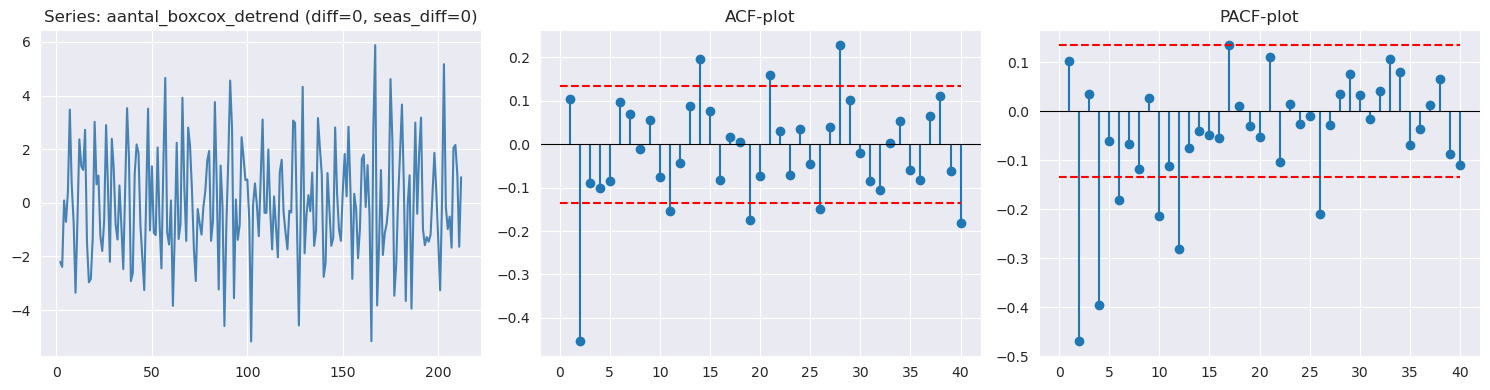

In [74]:
plot_series(aantallen, 'aantal_boxcox_detrend')